# Simple Example

## Introduction

In this example, we present an existing method [1] and our new method on a very simple simulated dataset. <br>
We compare both methods based on simplicity, goodness of fit and performance. <br>
<br>
[1] On the Analysis of Discrete Time Competing Risks Data, Biometrics, Lee et al. 2018

## Data Generation

We simulate N=50,000 patients, with 5 covariate $Z_p$ ($p \in [1,...,5]$) randomly sampled from $\mathbb{R} [0,1]$. <br> <br>
Our timeline is discrete, i.e $t \in [1,...,d]$. Here, we choose $d=30$. <br> <br>
The event type $J_i$ is randomly sampled from $J_i \sim Uniform[1,...,M]$, where $M$ is the number of competing events. In this example $M=2$. <br><br>
For each of the samples, we sample it's time-to-event $T_i$ from the hazard function $\lambda_{j}(T|Z) = \frac{exp(\alpha_{jt}+Z^{T}\beta_{j})}{1+exp(\alpha_{jt}+Z^{T}\beta_{j})}$ such that <br>
$\alpha_{1t} = -1-0.3 log(t)$ <br> 
$\beta_{1} = -log([0.8, 3, 3, 2.5, 2])$ <br> 
$\alpha_{2t} = -1.75-0.15 log(t)$ <br> 
$\beta_{2} = -log([1, 3, 4, 3, 2])$ <br> 

and randomly sample a censoring time $C_i$ such that $C_i \sim Uniform[1, ... , d]$. <br>
We then calculate $X_i = min(T_i, C_i)$ and for cencored samples we set the event type to be $J=0$. <br><br>
Lastly, we split the data into two separate datasets for training (75%) and for testing (25%).

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pydts.examples_utils.generate_simulations_data import generate_quick_start_df
import warnings
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import numpy as np

real_coef_dict = {
    "alpha": {
        1: lambda t: -1 - 0.3 * np.log(t),
        2: lambda t: -1.75 - 0.15 * np.log(t)
    },
    "beta": {
        1: -np.log([0.8, 3, 3, 2.5, 2]),
        2: -np.log([1, 3, 4, 3, 2])
    }
}

In [3]:
n_patients = 50000
n_cov = 5
patients_df = generate_quick_start_df(n_patients=n_patients, n_cov=n_cov, d_times=30, j_events=2, 
                                      pid_col='pid', seed=0, real_coef_dict=real_coef_dict)
covariates = [f'Z{i + 1}' for i in range(n_cov)]

train_df, test_df = train_test_split(patients_df, test_size=0.25)
events = sorted(train_df['J'].unique())
times = sorted(train_df['X'].unique())
train_df.head()  

,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X
31111,31111,0.661973,0.211958,0.770829,0.677775,0.653131,0,28,24,24
30206,30206,0.740999,0.927717,0.182855,0.897037,0.084195,0,20,17,17
44602,44602,0.442468,0.146094,0.137102,0.901129,0.077351,1,12,15,12
20383,20383,0.874138,0.374438,0.863105,0.472107,0.653651,0,30,17,17
32433,32433,0.748574,0.937747,0.171156,0.927878,0.666952,0,30,12,12


In [5]:
from pydts.fitters import repetitive_fitters
rep_dict, times_dict, counts_df = repetitive_fitters(rep=15, n_patients=n_patients, n_cov=n_cov, d_times=30,
                                                         j_events=2, pid_col='pid', test_size=0.25, verbose=0, 
                                                         allow_fails=20, real_coef_dict=real_coef_dict, 
                                                         censoring_prob=.8)


 40%|████████████████████████████████████                                                      | 14/35 [05:04<07:36, 21.73s/it]

final: 15


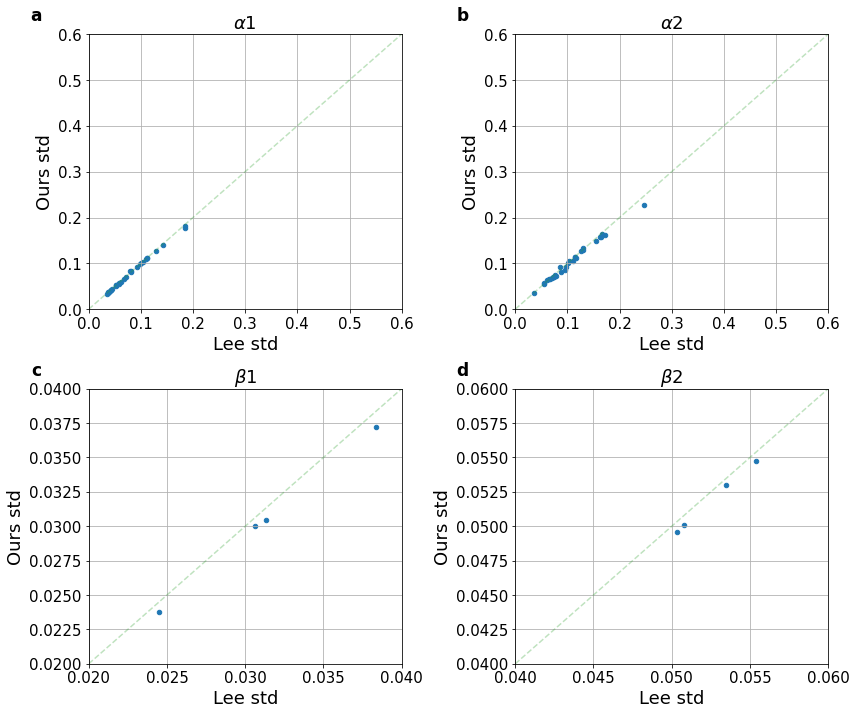

In [6]:
from pydts.examples_utils.plots import plot_reps_coef_std

new_res_dict = plot_reps_coef_std(rep_dict, True)

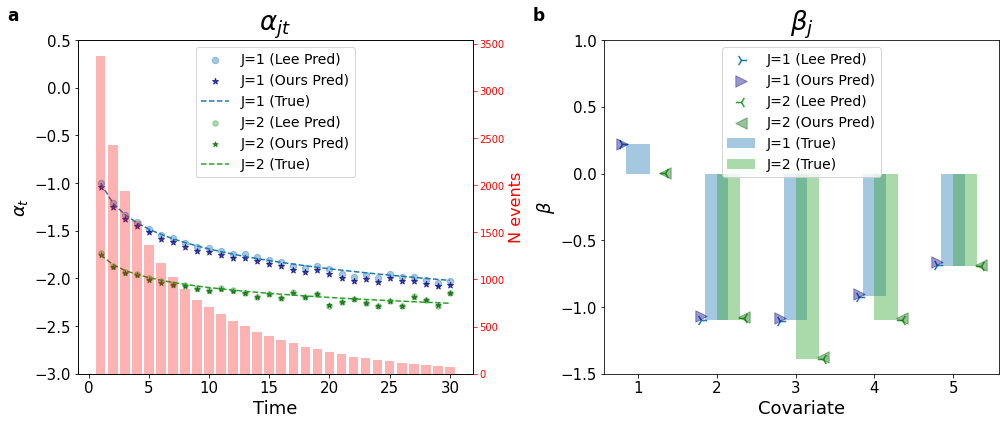

In [7]:
from pydts.examples_utils.plots import plot_models_coefficients
a = new_res_dict['alpha']
b = new_res_dict['beta']
times = train_df['X'].sort_values().unique()
n_cov = 5
temp_c_df = counts_df.loc[[1,2]].groupby(['X']).sum().values.flatten().astype(int)
plot_models_coefficients(a, b, times, temp_c_df)

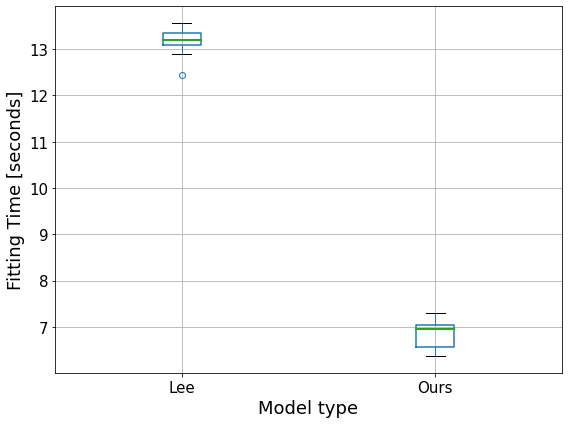

<AxesSubplot:xlabel='Model type', ylabel='Fitting Time [seconds]'>

In [8]:
from pydts.examples_utils.plots import plot_times

plot_times(times_dict)

## Lee et al. 2018 [1]

Lee et al. suggested to expand the data so that for each patient we have row for each $t \in [1, ... , T_i]$, with binary event columns which are 1 only at the time of the event. here $j_0 = 1 - j_1 - j_2$. <br> <br>
Then, for each event we estimate {$\alpha_{jt}, \beta_{j}$} using a binary regression model.

In [9]:
from pydts.fitters import DataExpansionFitter
fitter = DataExpansionFitter()
fitter.fit(df=train_df.drop(['C', 'T'], axis=1))
fitter.print_summary()



Model summary for event: 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    j_1   No. Observations:               357418
Model:                            GLM   Df Residuals:                   357383
Model Family:                Binomial   Df Model:                           34
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54259.
Date:                Mon, 11 Apr 2022   Deviance:                   1.0852e+05
Time:                        21:00:41   Pearson chi2:                 3.58e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01510
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C(X)[1]       -0.9516  

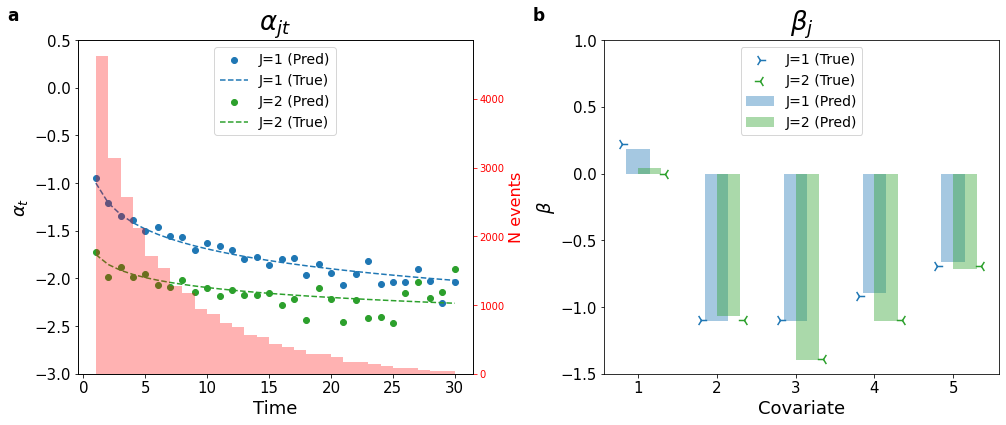

In [10]:
from pydts.examples_utils.plots import plot_first_model_coefs
plot_first_model_coefs(models=fitter.event_models, times=fitter.times, train_df=patients_df, n_cov=5)

## New approach

Here, for each event, we first estimate $\beta_{j}$ using a time-stratified CoxPH model and the expanded data as we used in the previous approach. <br> <br>
Afterwards, we evaluate $\alpha_{jt}$ based on the original training data.

In [11]:
from pydts.fitters import TwoStagesFitter
new_fitter = TwoStagesFitter()
new_fitter.fit(df=train_df.drop(['C', 'T'], axis=1))

new_fitter.print_summary()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.175630,0.029922,0.042164,0.045464
Z2,-1.077021,0.030535,-1.053325,0.046400
Z3,-1.072990,0.030744,-1.383865,0.047306
Z4,-0.868595,0.030434,-1.090288,0.046584
Z5,-0.643514,0.030250,-0.709322,0.046064




Model summary for event: 1


n_jt  success  alpha_jt
J X                          
1 1   2560     True -0.993701
  2   1713     True -1.252696
  3   1321     True -1.390031
  4   1123     True -1.426362
  5    888     True -1.545886
  6    823     True -1.506916
  7    675     True -1.602185
  8    603     True -1.610078
  9    473     True -1.746932
  10   458     True -1.675599
  11   400     True -1.706351
  12   346     True -1.745275
  13   283     True -1.841762
  14   259     True -1.824197
  15   213     True -1.905305
  16   203     True -1.841176
  17   182     True -1.832710
  18   135     True -2.017525
  19   135     True -1.886645
  20   108     True -1.990557
  21    83     True -2.119080
  22    82     True -1.999757
  23    80     True -1.859465
  24    53     True -2.100951
  25    45     True -2.080507
  26    36     True -2.081074
  27    32     True -1.950757
  28    20     True -2.072971
  29    10     True -2.292853
  30     6     True -2.089735



Model summary for event: 2


n_jt  success  alpha_jt
J X                          
2 1    942     True -1.741469
  2    617     True -2.004244
  3    596     True -1.891698
  4    472     True -2.003929
  5    430     True -1.973737
  6    341     True -2.086884
  7    299     True -2.104953
  8    288     True -2.034741
  9    228     True -2.150781
  10   214     True -2.110933
  11   176     True -2.191509
  12   168     True -2.131838
  13   143     True -2.180693
  14   129     True -2.175601
  15   117     True -2.157802
  16    92     True -2.267452
  17    87     True -2.209869
  18    62     True -2.440465
  19    76     True -2.107629
  20    60     True -2.200231
  21    41     True -2.457340
  22    45     True -2.212729
  23    32     True -2.418286
  24    27     True -2.404584
  25    21     True -2.465084
  26    23     True -2.142334
  27    20     True -2.045518
  28    12     True -2.190062
  29     8     True -2.137646
  30     5     True -1.913849

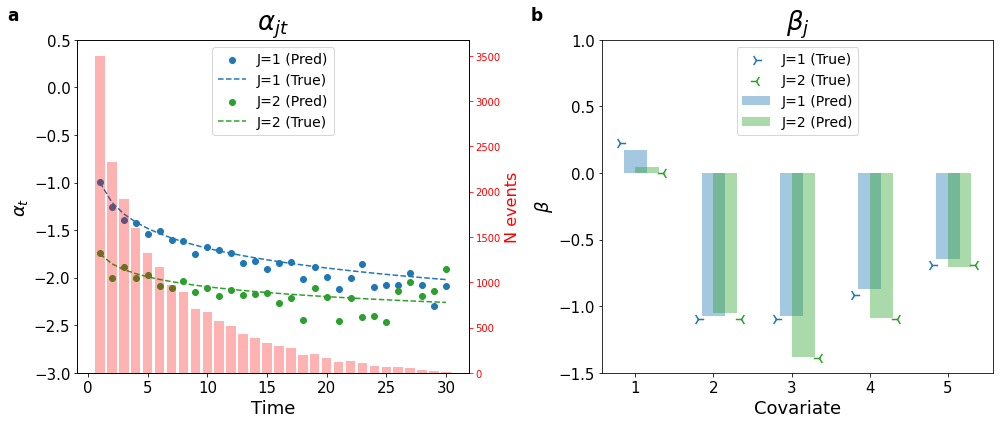

In [12]:
from pydts.examples_utils.plots import plot_second_model_coefs
plot_second_model_coefs(new_fitter.alpha_df, new_fitter.beta_models, times, n_cov=5)

In [13]:
new_fitter.get_beta_SE()

,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.175630,0.029922,0.042164,0.045464
Z2,-1.077021,0.030535,-1.053325,0.046400
Z3,-1.072990,0.030744,-1.383865,0.047306
Z4,-0.868595,0.030434,-1.090288,0.046584
Z5,-0.643514,0.030250,-0.709322,0.046064


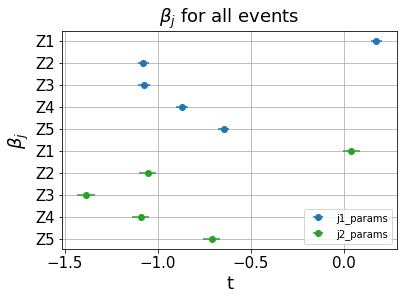

<AxesSubplot:title={'center':'$\\beta_{j}$ for all events'}, xlabel='t', ylabel='$\\beta_{j}$'>

In [14]:
new_fitter.plot_all_events_beta()

## Prediction

In [15]:
# pred_df = new_fitter.predict_cumulative_incident_function(test_df)
# pred_df = new_fitter.predict_marginal_prob_all_events(pred_df)
# pred_df.set_index(['pid']).head().T
pred_df = new_fitter.predict_cumulative_incident_function(
    patients_df.drop(['J', 'T', 'C', 'X'], axis=1).head(3)).set_index('pid').T
pred_df

pid,0,1,2
Z1,0.548814,0.645894,0.791725
Z2,0.715189,0.437587,0.528895
Z3,0.602763,0.891773,0.568045
Z4,0.544883,0.963663,0.925597
Z5,0.423655,0.383442,0.071036
overall_survival_t1,0.940455,0.958727,0.930894
overall_survival_t2,0.896901,0.928018,0.880776
overall_survival_t3,0.858059,0.900500,0.836577
overall_survival_t4,0.822953,0.875209,0.796861
overall_survival_t5,0.791664,0.852514,0.761776


## Comparison (WIP)

In [16]:
pd.DataFrame(index=pd.MultiIndex.from_product([['d=30', 'd=60', 'd=100', 'd=150'],
                                               ['N=1000', 'N=10000', 'N=100000']], names=['N', 'D']), 
             columns=['Train MSE (oracle)', 'Test MSE (oracle)', 'computation time'])

Train MSE (oracle) Test MSE (oracle) computation time
N     D                                                             
d=30  N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=60  N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=100 N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=150 N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN

In [17]:
from pydts.examples_utils.plots import compare_beta_models_for_example
from pydts.utils import present_coefs

res_dict = compare_beta_models_for_example(fitter.event_models, new_fitter.event_models,
                                           real_coef_dict=real_coef_dict)

present_coefs(res_dict)

for coef: Alpha


,Lee,Ours,real
a1_1,-0.951613,-0.993701,-1.000000
a2_1,-1.209701,-1.252696,-1.207944
a3_1,-1.347113,-1.390031,-1.329584
a4_1,-1.383203,-1.426362,-1.415888
a5_1,-1.504718,-1.545886,-1.482831
a6_1,-1.464485,-1.506916,-1.537528
a7_1,-1.556570,-1.602185,-1.583773
a8_1,-1.564112,-1.610078,-1.623832
a9_1,-1.701809,-1.746932,-1.659167
a10_1,-1.629386,-1.675599,-1.690776


for coef: Beta


,Lee,Ours,real
Z1_1,0.180473,0.175630,0.223144
Z2_1,-1.106470,-1.077021,-1.098612
Z3_1,-1.103171,-1.072990,-1.098612
Z4_1,-0.893110,-0.868595,-0.916291
Z5_1,-0.662878,-0.643514,-0.693147
Z1_2,0.043267,0.042164,-0.000000
Z2_2,-1.065630,-1.053325,-1.098612
Z3_2,-1.398985,-1.383865,-1.386294
Z4_2,-1.103417,-1.090288,-1.098612
Z5_2,-0.717390,-0.709322,-0.693147


In [18]:
from pydts.utils import create_df_for_cif_plots

df_for_plotting = create_df_for_cif_plots(test_df, field="Z1", covariates=new_fitter.covariates,
                                                     quantiles=[0.25, 0.5, 0.75], zero_others=True )
our_pred_df = new_fitter.predict_cumulative_incident_function(df_for_plotting)
our_pred_df = new_fitter.predict_marginal_prob_all_events(our_pred_df)

our_pred_df.head()

,Z1,Z2,Z3,Z4,Z5,overall_survival_t1,overall_survival_t2,overall_survival_t3,overall_survival_t4,overall_survival_t5,...,cif_j2_at_t23,cif_j2_at_t24,cif_j2_at_t25,cif_j2_at_t26,cif_j2_at_t27,cif_j2_at_t28,cif_j2_at_t29,cif_j2_at_t30,marginal_prob_j1,marginal_prob_j2
4839,0.0,0.0,0.0,0.0,0.243417,0.631056,0.442886,0.315257,0.229430,0.170053,...,0.364988,0.365165,0.365304,0.365462,0.365601,0.365699,0.365782,0.365867,0.633525,0.365867
4839,0.0,0.0,0.0,0.0,0.500401,0.679022,0.503913,0.378672,0.289830,0.225325,...,0.360397,0.360784,0.361097,0.361463,0.361798,0.362040,0.362254,0.362479,0.635543,0.362479
4839,0.0,0.0,0.0,0.0,0.747769,0.720322,0.559291,0.439098,0.350075,0.282876,...,0.355102,0.355810,0.356398,0.357100,0.357763,0.358255,0.358703,0.359186,0.635681,0.359186


In [19]:
lee_pred_df = fitter.predict_cumulative_incident_function(df_for_plotting)
lee_pred_df = fitter.predict_marginal_prob_all_events(lee_pred_df)

lee_pred_df.head()

,Z1,Z2,Z3,Z4,Z5,overall_survival_t1,overall_survival_t2,overall_survival_t3,overall_survival_t4,overall_survival_t5,...,cif_j2_at_t23,cif_j2_at_t24,cif_j2_at_t25,cif_j2_at_t26,cif_j2_at_t27,cif_j2_at_t28,cif_j2_at_t29,cif_j2_at_t30,marginal_prob_j1,marginal_prob_j2
4839,0.0,0.0,0.0,0.0,0.243417,0.622522,0.432165,0.304894,0.219752,0.161469,...,0.360272,0.360424,0.360542,0.360674,0.360793,0.360873,0.360942,0.361014,0.638481,0.361014
4839,0.0,0.0,0.0,0.0,0.500401,0.672343,0.494985,0.369589,0.280878,0.216988,...,0.356064,0.356410,0.356688,0.357008,0.357306,0.357515,0.357701,0.357901,0.640369,0.357901
4839,0.0,0.0,0.0,0.0,0.747769,0.715208,0.552098,0.431488,0.342238,0.275283,...,0.351235,0.351888,0.352424,0.353061,0.353669,0.354110,0.354513,0.354958,0.640371,0.354958


In [20]:
from pydts.utils import get_real_hazard

df_temp = get_real_hazard(df_for_plotting.copy(), real_coef_dict=real_coef_dict, times=times, events=[1,2])
df_temp

,Z1,Z2,Z3,Z4,Z5,hazard_j1_t1,hazard_j1_t2,hazard_j1_t3,hazard_j1_t4,hazard_j1_t5,...,hazard_j2_t21,hazard_j2_t22,hazard_j2_t23,hazard_j2_t24,hazard_j2_t25,hazard_j2_t26,hazard_j2_t27,hazard_j2_t28,hazard_j2_t29,hazard_j2_t30
4839,0.0,0.0,0.0,0.0,0.243417,0.237086,0.201545,0.182678,0.170143,0.160899,...,0.085068,0.084526,0.084012,0.083522,0.083054,0.082607,0.082179,0.081769,0.081374,0.080995
4839,0.0,0.0,0.0,0.0,0.500401,0.206386,0.174395,0.157568,0.146448,0.138276,...,0.072190,0.071724,0.071281,0.070860,0.070457,0.070073,0.069705,0.069352,0.069013,0.068687
4839,0.0,0.0,0.0,0.0,0.747769,0.179710,0.151067,0.136120,0.126286,0.119083,...,0.061515,0.061113,0.060732,0.060368,0.060022,0.059691,0.059374,0.059070,0.058778,0.058497


In [21]:
real_pred_df = new_fitter.predict_cumulative_incident_function(df_temp)
real_pred_df = new_fitter.predict_marginal_prob_all_events(real_pred_df)

real_pred_df.head()

,Z1,Z2,Z3,Z4,Z5,hazard_j1_t1,hazard_j1_t2,hazard_j1_t3,hazard_j1_t4,hazard_j1_t5,...,cif_j2_at_t23,cif_j2_at_t24,cif_j2_at_t25,cif_j2_at_t26,cif_j2_at_t27,cif_j2_at_t28,cif_j2_at_t29,cif_j2_at_t30,marginal_prob_j1,marginal_prob_j2
4839,0.0,0.0,0.0,0.0,0.243417,0.237086,0.201545,0.182678,0.170143,0.160899,...,0.370878,0.371048,0.371185,0.371296,0.371385,0.371458,0.371517,0.371565,0.627952,0.371565
4839,0.0,0.0,0.0,0.0,0.500401,0.206386,0.174395,0.157568,0.146448,0.138276,...,0.369938,0.370337,0.370670,0.370948,0.371180,0.371375,0.371538,0.371675,0.626635,0.371675
4839,0.0,0.0,0.0,0.0,0.747769,0.179710,0.151067,0.136120,0.126286,0.119083,...,0.368287,0.369058,0.369719,0.370286,0.370774,0.371193,0.371555,0.371867,0.623498,0.371867


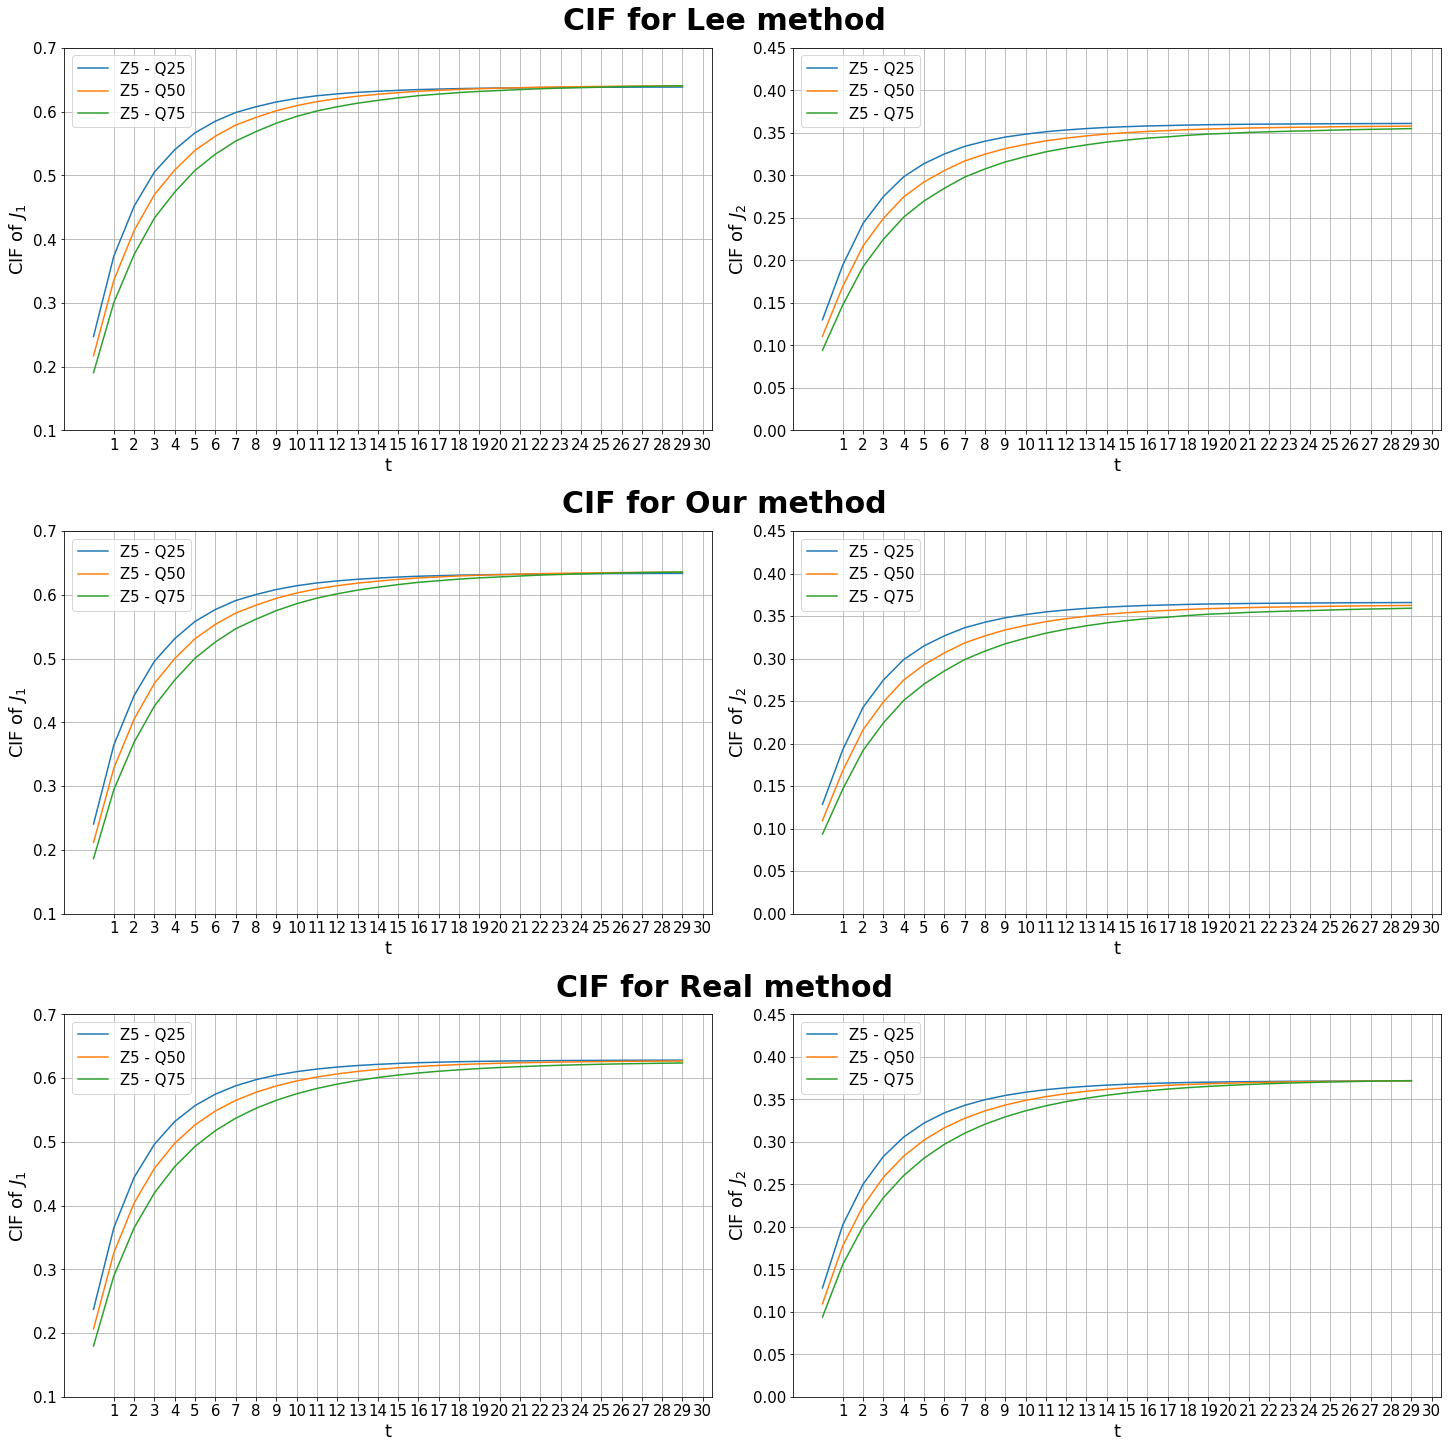

In [22]:
import matplotlib.pyplot as plt
from pydts.examples_utils.plots import plot_cif_plots

j_events = 2
preds = [lee_pred_df, our_pred_df, real_pred_df]
names = ['Lee', 'Our', 'Real']

fig = plt.figure(constrained_layout=True, figsize=(20, 20))

subfigs = fig.subfigures(nrows=len(preds), ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'CIF for {names[row]} method', fontsize=30, fontweight='bold')
    pred_df = preds[row]
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=j_events)
    for col, ax in enumerate(axs):
        ax = plot_cif_plots(pred_df, event=col+1, return_ax=True, ax=ax, pad=0.05, scale=5)
        h, l = ax.get_legend_handles_labels()
        ax.legend(h,["Z5 - Q25", "Z5 - Q50", "Z5 - Q75"], fontsize=15)